# Twitter Analysis of the APTA Next 2017 Conference

First I'll import the libraries that are needed

In [1]:
%matplotlib inline
import pymongo
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## APTA Next 2017 Day 2 Analysis

### Data Wrangling
Before I can analyze anything, I need to get the data out of my database and organize it into a form that can easily be analyzed. 

First I'll make a connection to my database. Everything is stored in a database called MongoDB on my laptop. 

In [2]:
client_con = pymongo.MongoClient()

In [3]:
client_con.database_names()

[u'local', u'test']

In [4]:
local_db = client_con['test']

In [5]:
local_db.collection_names()

[u'Next2017Day1',
 u'twitter_data',
 u'ep3',
 u'ep3west',
 u'Next2017Day3',
 u'tweet_practice',
 u'McMillan',
 u'Next2017Day2']

'Next2017' is the collection with the data from .  
I'll load the data into a variable called data_set

In [6]:
data_set = local_db['Next2017Day2']

Next I'll take a quick look at how many tweets are in there

In [7]:
data_set.count()

2198

Now I need to change the format of the data to something easier to look at.
First, I'll make the database collection into a list of dictionaries, which is easier to work with in Python

In [8]:
tweet_data = list(data_set.find())

Next I'll make that list into a dataframe, which looks more like a spread sheet
I'm going to make it a function that I can use over again for the west data set

In [9]:
def process_results(results):
    id_list = [tweet['id'] for tweet in results]
    data_set = pd.DataFrame(id_list, columns = ["id"])
    
    data_set['user'] = [tweet['user']['screen_name'] for tweet in results]
    data_set["text"] = [tweet['text'] for tweet in results]
    data_set["retweet_count"] = [tweet['retweet_count'] for tweet in results]
    data_set["favorite_count"] = [tweet['favorite_count'] for tweet in results]
    data_set["created_at"] = [tweet['created_at'] for tweet in results]
    
    return data_set

Now I'll use that function to process my data into the dataframe and store it in a variable df

In [10]:
df_NextD2 = process_results(tweet_data)

Let's take a look at it.  
First I'll check the length, hopefully it's the same as my number of records above.  
Then I'll look at the top 5 rows and the bottom 5 rows to make sure it all looks right.

In [11]:
len(df_NextD2)

2198

In [12]:
df_NextD2.head()

,id,user,text,retweet_count,favorite_count,created_at
0,878427862633730049,DrBryanStewart,"RT @alanleeDPT: Now, Don't miss these topic of...",1,0,Sat Jun 24 01:41:37 +0000 2017
1,878427339708932096,JustinJorgensen,"RT @RJPeacockSPT: ""Exercise is movement and mo...",5,0,Sat Jun 24 01:39:32 +0000 2017
2,878425535243747328,JustinJorgensen,"RT @RJPeacockSPT: Dr. Shields ""The new frontie...",4,0,Sat Jun 24 01:32:22 +0000 2017
3,878424520658493440,AcuteCareAPTA,RT @RehabHopkins: Johns Hopkins Activity Mobil...,2,0,Sat Jun 24 01:28:20 +0000 2017
4,878424001927892993,onobeth,RT @APTAnext: The #Oxford Debate is under way ...,3,0,Sat Jun 24 01:26:17 +0000 2017


In [13]:
df_NextD2.tail()

,id,user,text,retweet_count,favorite_count,created_at
2193,875084686019760128,FOXRehab,Want to know #WhereToFindFOX? We'll be at #APT...,1,2,Wed Jun 14 20:17:02 +0000 2017
2194,875077222859776002,LiamNardoe,Looking forward to @APTAnext conference in my ...,0,3,Wed Jun 14 19:47:22 +0000 2017
2195,875054060478623745,PTPintcast,We'll see you in Boston @APTAnext #APTANEXT #D...,0,2,Wed Jun 14 18:15:20 +0000 2017
2196,875019369411215360,Kendra_PT4Life,RT @APTAnext: Here we go...our annual list of ...,15,0,Wed Jun 14 15:57:29 +0000 2017
2197,875009642409189376,ihartrecruit,Don't forget to stop by the @DignityHlthJobs b...,0,1,Wed Jun 14 15:18:50 +0000 2017


It all looks good.  
Now I need to change the 'created_at' column to a different format that will make is easier for me to split up the data sets. 

In [14]:
df_NextD2['created_at'] = pd.to_datetime(df_NextD2['created_at'])

In [15]:
df_NextD2.head()

,id,user,text,retweet_count,favorite_count,created_at
0,878427862633730049,DrBryanStewart,"RT @alanleeDPT: Now, Don't miss these topic of...",1,0,2017-06-24 01:41:37
1,878427339708932096,JustinJorgensen,"RT @RJPeacockSPT: ""Exercise is movement and mo...",5,0,2017-06-24 01:39:32
2,878425535243747328,JustinJorgensen,"RT @RJPeacockSPT: Dr. Shields ""The new frontie...",4,0,2017-06-24 01:32:22
3,878424520658493440,AcuteCareAPTA,RT @RehabHopkins: Johns Hopkins Activity Mobil...,2,0,2017-06-24 01:28:20
4,878424001927892993,onobeth,RT @APTAnext: The #Oxford Debate is under way ...,3,0,2017-06-24 01:26:17


I collected the data on the second official day of the conference (Friday, June 23) and am really interested in learning about what happened on that day, so I'm only going to look at tweets from that day. Below I'll get rid of all ofthe ones before June 23, and that occurred after midnight on June 23 (we'll include those in the day 3 analysis). 

In [17]:
df1 = df_NextD2[df_NextD2['created_at'] > '2017-06-23']
df_NextD2 = df1[df1['created_at'] < '2017-06-24']
len(df_NextD2)

686

Now I'll make a new column that adds retweets plus favorites. That will give some idea of the importance of a particular tweet. 

In [18]:
df_NextD2['important_tweets'] = df_NextD2['retweet_count'] + df_NextD2['favorite_count']
df_NextD2.head()

/Users/Cody/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,id,user,text,retweet_count,favorite_count,created_at,important_tweets
20,878399533314715648,acapt2,RT @APTAtweets: Miss last night's unforgettabl...,14,0,2017-06-23 23:49:03,14
21,878398597506764801,acapt2,RT @TimRethornSPT: Both @APTAtweets and @acapt...,1,0,2017-06-23 23:45:20,1
22,878396097370214400,EThoesDPT,"RT @RJPeacockSPT: ""Exercise is movement and mo...",5,0,2017-06-23 23:35:24,5
23,878392199028854784,ayddin1,What a fun debate!! Had lots of laugh! #APTANE...,0,1,2017-06-23 23:19:54,1
24,878391799215255552,TheSteph21,Harbor view is the best view #APTAnext https:/...,0,0,2017-06-23 23:18:19,0


Next, we to adjust the data set to only look at origional tweets, not retweets. 

First, I'll make a column looking at whether or not is was retweeted

In [19]:
df_NextD2['retweeted'] = df_NextD2['text'].str.startswith('RT')

/Users/Cody/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [21]:
df_NextD2.head()

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
20,878399533314715648,acapt2,RT @APTAtweets: Miss last night's unforgettabl...,14,0,2017-06-23 23:49:03,14,True
21,878398597506764801,acapt2,RT @TimRethornSPT: Both @APTAtweets and @acapt...,1,0,2017-06-23 23:45:20,1,True
22,878396097370214400,EThoesDPT,"RT @RJPeacockSPT: ""Exercise is movement and mo...",5,0,2017-06-23 23:35:24,5,True
23,878392199028854784,ayddin1,What a fun debate!! Had lots of laugh! #APTANE...,0,1,2017-06-23 23:19:54,1,False
24,878391799215255552,TheSteph21,Harbor view is the best view #APTAnext https:/...,0,0,2017-06-23 23:18:19,0,False


### Total Tweets
Now I'll include only the origional tweets in the data set. 
Then I'll look at how many we have

In [22]:
df_NextD2 = df_NextD2[df_NextD2['retweeted'] == False]
len(df_NextD2)

397

### Total Retweets and Total Favorites
Next, let's look at some numbers from the full conference data set.   
We have total tweets (664). Let's also look at total retweets and total favorites

In [23]:
nextD2_retweets = df_NextD2['retweet_count'].sum()
print nextD2_retweets
nextD2_favorites = df_NextD2['favorite_count'].sum()
print nextD2_favorites

279
993


## Top 10 Tweets from 
Now let's look at the 10 most importatn tweets.  
First we'll sort the data by "important_tweets" to with highest number on top.  
Then we'll show the top 10
If you want to see the origional tweet, just go to http://twitter.com/statuses/ and put the tweet ID at the end after that last "/"

In [24]:
sorted_NextD2 = df_NextD2.sort_values(['important_tweets'], ascending = False)
sorted_NextD2.head(10)

,id,user,text,retweet_count,favorite_count,created_at,important_tweets,retweeted
669,878056660052451328,Foundation4PT,Big News out of the FPT during PT PARTY at #AP...,14,30,2017-06-23 01:06:35,44,False
547,878233527036166144,policy4pt,On shoulders of giants. @APTAtweets President...,7,29,2017-06-23 12:49:24,36,False
695,878049676242673664,Foundation4PT,HAPPENING NOW: Stanley Paris &amp; Catherine P...,5,25,2017-06-23 00:38:50,30,False
367,878261033391054848,APTAnext,"""You cannot measure the added value of innovat...",9,17,2017-06-23 14:38:42,26,False
277,878282489009127425,gilligggan_spt,I took @DunnSdunn2's advice and decided to #Be...,0,21,2017-06-23 16:03:57,21,False
535,878238967673405442,johnnyowensCFI,Excited to present our #BFR talk tomorrow with...,1,19,2017-06-23 13:11:01,20,False
440,878256759667806208,policy4pt,"To create culture.. articulate it, measure it...",6,13,2017-06-23 14:21:43,19,False
339,878263655225204736,APTAnext,"""If research results are not adopted into cont...",7,10,2017-06-23 14:49:07,17,False
491,878253739538227201,APTAnext,"The 22nd John H.P. #Maley Lecture, ""Strike Whi...",5,11,2017-06-23 14:09:43,16,False
104,878358785219108864,APTAnext,That's how you fire up an #Oxford Debate crowd...,2,14,2017-06-23 21:07:08,16,False


### Word Cloud
The Last step for the full conference analysis is the Word Cloud

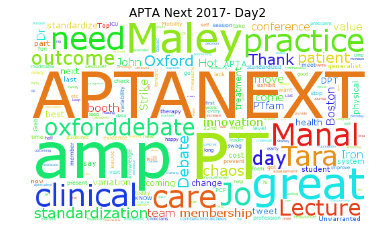

In [25]:
text = " ".join(df_NextD2["text"].values)
no_url_no_tag = " ".join([word for word in text.split(' ')
                        if 'http' not in word
                        and not word.startswith('@')
                        and word != 'RT'
                        and word != 'APTANEXT'])
wc = WordCloud(background_color="white", font_path="/Library/Fonts/Verdana.ttf", stopwords=STOPWORDS, width=500, height=300)
wc.generate(no_url_no_tag)
plt.imshow(wc)
plt.axis("off")
plt.title("APTA Next 2017- Day2")
plt.savefig('Next2017D2.png', dpi=500)
plt.show()

That's it!  
Hopefully you found this interesting.  
If you did, let me know at [@CodyWeisbach](http://twitter.com/codyweisbach) on Twitter and I'll keep it up!